# Co-planar waveguide in RF photonics part 1: basic transmission line benchmark

**Note**: this notebook requires Tidy3D version 2.10.0rc1 or later.

The co-planar waveguide (CPW) is a transmission line commonly used in RF photonics due to its compact planar nature, ease of fabrication, and resistance to external EM interference. In this notebook series, we will examine the CPW in the context of a Mach-Zehnder modulator (MZM).

In part one (this notebook), we will start with a simple CPW on a dielectric substrate. The goal is to demonstrate the typical 2D and 3D workflow in Tidy3D's RF solver. We will also benchmark key results against other commercial RF simulation software.

In [part two](https://www.flexcompute.com/tidy3d/examples/notebooks/CPWRFPhotonics2/), we will simulate the CPW with the MZM optical waveguide. A 2D mode analysis will first be performed on the conventional layout, followed by a 3D simulation of segmented electrode design. 

<center><img src="./img/cpw_rf_photonics_1_render.png" width=480 /></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.rf as rf
from tidy3d import web

td.config.logging.level = "ERROR"

## Building the simulation

### Key parameters

We start by defining some key parameters. 

In [2]:
# Frequency range
f_min, f_max = (1e9, 65e9)
f0 = (f_max + f_min) / 2
freqs = np.linspace(f_min, f_max, 201)

The CPW dimensions are defined below. 

In [3]:
# Key dimensions
len_inf = 1e5  # Effective infinity
G = 5  # CPW gap
WS = 30  # Signal trace width
WG = 350  # Ground trace width
T = 1  # Conductor thickness
H = len_inf  # Substrate thickness
W_sub = len_inf  # Substrate width
W_cpw = WS + 2 * (G + WG)  # Total CPW width
L = 2000  # Waveguide length

### Material and Geometry

The substrate is assumed to be lossless. The metal is assumed to have constant conductivity over the frequency range. 

In [4]:
# Material properties
cond = 41  # Conductivity in S/um
eps = 4.5  # Relative permittivity, substrate

# Define EM mediums
med_sub = td.Medium(permittivity=eps)
med_metal = rf.LossyMetalMedium(conductivity=cond, frequency_range=(f_min, f_max))

The CPW geometry is created below. The substrate is assumed to occupy the lower half-space of the simulation domain. 

In [5]:
# Create substrate
str_sub_layer = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-W_sub / 2, -H, -len_inf), rmax=(W_sub / 2, 0, len_inf)),
    medium=med_sub,
)

# Create CPW
geom_sig = td.Box.from_bounds(rmin=(-WS / 2, 0, -len_inf), rmax=(WS / 2, T, len_inf))
geom_gnd1 = td.Box.from_bounds(rmin=(-WS / 2 - G - WG, 0, -len_inf), rmax=(-WS / 2 - G, T, len_inf))
geom_gnd2 = geom_gnd1.reflected((1, 0, 0))
geom_cpw = td.GeometryGroup(geometries=[geom_sig, geom_gnd1, geom_gnd2])
str_cpw = td.Structure(geometry=geom_cpw, medium=med_metal)

# Full structure list
structure_list = [str_sub_layer, str_cpw]

### Grid and Boundary

The simulation domain is surrounded by Perfectly Matched Layers (PMLs) by default. We add quarter-wavelength padding on all sides of the simulation to ensure that the external boundaries do not encroach on the near-field. 

In [6]:
# Define simulation size
padding = td.C_0 / f_max / 4
sim_LX = W_cpw + 2 * padding
sim_LY = W_cpw + 2 * padding
sim_LZ = L + 2 * padding

The simulation grid is automatically generated based on the minimum wavelength in the respective dielectric medium. In RF problems, the field is especially enhanced near metallic structures. For more accurate results, we use the `LayerRefinementSpec` feature to automatically refine the grid near metallic edges and corners. 

To learn more about the `LayerRefinementSpec` feature, please refer to the [API documentation page](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LayerRefinementSpec.html) or the [tutorial page](https://www.flexcompute.com/tidy3d/examples/notebooks/LayerRefinement/). 

In [7]:
# Define Layer refinement spec
lr_spec = rf.LayerRefinementSpec.from_structures(
    structures=[str_cpw],
    min_steps_along_axis=5,
    corner_refinement=td.GridRefinement(dl=T / 5, num_cells=2),
    refinement_inside_sim_only=False,
)

# Overall grid specification
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=12,
    wavelength=td.C_0 / f_max,
    layer_refinement_specs=[lr_spec],
)

### Monitors

We define a field monitor for visualization purposes below. 

In [8]:
mon_1 = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, 0, td.inf), freqs=[f_min, f0, f_max], name="field cpw plane"
)

monitor_list = [mon_1]

### Wave Ports

Wave ports are used to excite the CPW. It is important to ensure that the width of the ports are slightly smaller than the overall width spanned by the CPW side ground traces. We also define voltage and current specifications used to calculate the port impedance. 

In [9]:
# Define current integration path (loop)
current_spec = rf.AxisAlignedCurrentIntegralSpec(
    center=(0, T / 2, -L / 2), size=(WS + G, 5 * T, 0), sign="+"
)
# Define voltage integration path (line)
voltage_spec = rf.AxisAlignedVoltageIntegralSpec(
    center=((WS + G) / 2, T / 2, -L / 2),
    size=(G, 0, 0),
    sign="-",
)
# Define specification for computing characteristic impedance
Z_VI_impedance_spec = rf.CustomImpedanceSpec(voltage_spec=voltage_spec, current_spec=current_spec)
# Define port specification
wave_port_mode_spec = rf.MicrowaveModeSpec(
    num_modes=1, target_neff=np.sqrt((eps + 1) / 2), impedance_specs=(Z_VI_impedance_spec,)
)
# Define wave ports
WP1 = rf.WavePort(
    center=(0, 0, -L / 2),
    size=(W_cpw - 50, W_cpw - 50, 0),
    mode_spec=wave_port_mode_spec,
    direction="+",
    name="WP1",
)
# Update the mode spec for the second wave port. We only need to update the sign of the current specification, since coordinates along
# the longitudinal direction are ignored, and the ports are identical in the transverse plane.
wave_port_mode_spec = wave_port_mode_spec.updated_copy(
    path="impedance_specs/0/", current_spec=current_spec.updated_copy(sign="-")
)
WP2 = WP1.updated_copy(
    center=(0, 0, L / 2),
    mode_spec=wave_port_mode_spec,
    direction="-",
    name="WP2",
)

# List of all ports
port_list = [WP1, WP2]

### Define Simulation and `TerminalComponentModeler`

The base `Simulation` object contains information about the overall simulation environment. The `TerminalComponentModeler` object is used in 3D simulations to conduct a port and frequency sweep in order to obtain the full S-parameter matrix. 

In [10]:
# Define base simulation
sim = td.Simulation(
    size=(sim_LX, sim_LY, sim_LZ),
    grid_spec=grid_spec,
    structures=structure_list,
    monitors=monitor_list,
    run_time=1e-9,
    symmetry=(1, 0, 0),
    shutoff=1e-8,
)

In [11]:
# Define TerminalComponentModeler
tcm = rf.TerminalComponentModeler(
    simulation=sim,
    ports=port_list,
    freqs=freqs,
)

### Visualization

We can inspect the grid to ensure a suitable level of refinement. The plots below show the full CPW (left) and the CPW gap (right). 

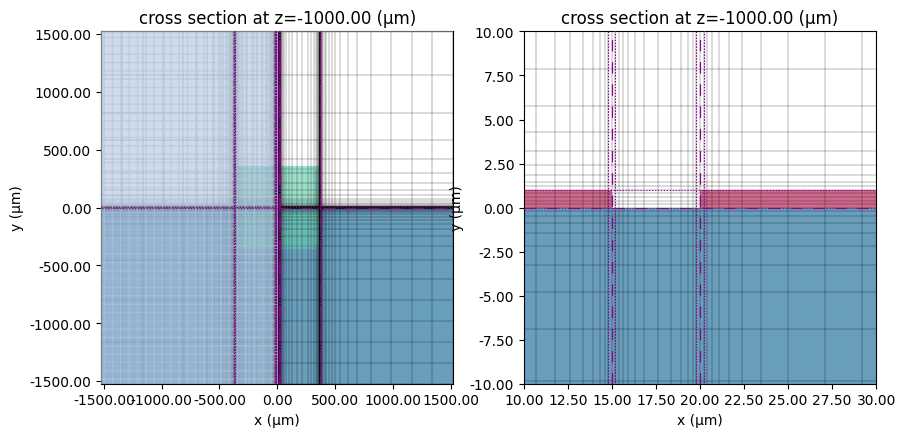

In [12]:
# Inspect transverse grid
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
tcm.plot_sim(z=-L / 2, ax=ax[0], monitor_alpha=0)
sim.plot_grid(z=-L / 2, ax=ax[0], hlim=(-sim_LX / 2, sim_LX / 2), vlim=(-sim_LY / 2, sim_LY / 2))
sim.plot(z=-L / 2, ax=ax[1], monitor_alpha=0)
sim.plot_grid(z=-L / 2, ax=ax[1], hlim=(10, 30), vlim=(-10, 10))
plt.show()

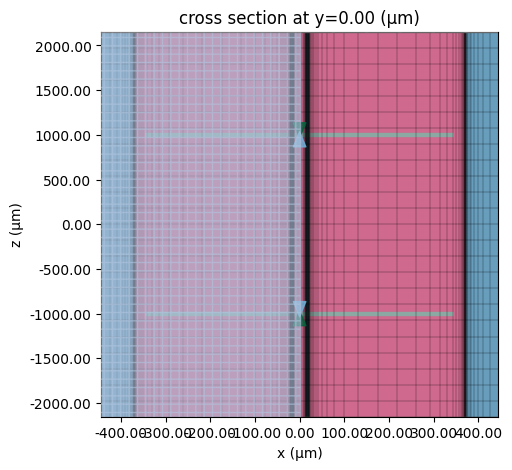

In [13]:
# Plot top view and wave ports (green/blue)
fig, ax = plt.subplots(figsize=(12, 5))
sim.plot_grid(y=0, ax=ax)
tcm.plot_sim(
    y=0.0, ax=ax, monitor_alpha=0, vlim=(-sim_LZ / 2, sim_LZ / 2), hlim=(-W_cpw * 0.6, 0.6 * W_cpw)
)
ax.set_aspect(0.2)
plt.show()

## 2D Analysis

In this section, we will perform a 2D mode analysis on the CPW and extract key transmission line parameters. 

### Run Mode Solver

The 2D mode analysis is performed with a `ModeSolver` object. We can easily create one from the wave port using the `to_mode_solver()` method. 

In [14]:
# Obtain mode solver from wave port
mode_solver = WP1.to_mode_solver(simulation=sim, freqs=freqs)

We run the mode solver below. 

In [15]:
# Run mode solver
mode_data = web.run(mode_solver, task_name="CPW mode solver", path="data/WP1_mode_data.hdf5")

17:14:00 EST Created task 'CPW mode solver' with resource_id                    
             'mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0' and task_type            
             'MODE_SOLVER'.

             View task using web UI at                                          
             ]8;id=977091;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=708214;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\taskId]8;;\]8;id=977091;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\=]8;;\]8;id=621195;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\mo]8;;\]8;id=977091;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\-2f761aa2-99ba-]8;;\
             ]8;id=977091;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\47d6-89c6-209f03d9e8b0']8;;\.

             Task folder: ]8;id=316622;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

17:14:06 EST Estimated FlexCredit cost: 0.022. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

17:14:07 EST status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:14:19 EST starting up solver

             running solver

17:14:29 EST status = success

             View simulation result at                                          
             ]8;id=232991;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=696028;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\taskId]8;;\]8;id=232991;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\=]8;;\]8;id=29034;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\mo]8;;\]8;id=232991;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\-2f761aa2-99ba-]8;;\
             ]8;id=232991;https://tidy3d.simulation.cloud/workbench?taskId=mo-2f761aa2-99ba-47d6-89c6-209f03d9e8b0\47d6-89c6-209f03d9e8b0']8;;\.

Output()

17:14:33 EST Loading simulation from data/WP1_mode_data.hdf5

### Mode Profile

First, let us examine the mode profile. The left plot depicts $\text{Re}(E_x)$ while the right plot shows the field magnitude in dB. (The divide-by-zero warnings are due to the field magnitude being zero in the metallic regions.)

/home/dmarek/dev/custom_tidy/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


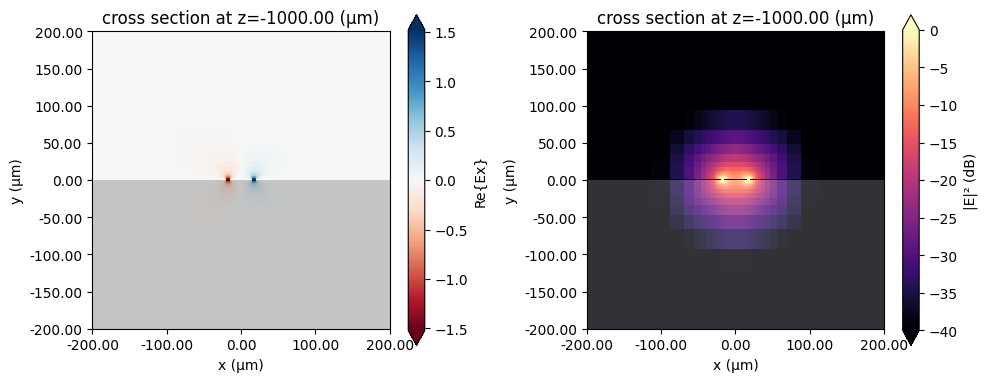

In [16]:
# Preview mode field
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
mode_solver.plot_field(field_name="Ex", val="real", f=f_max, mode_index=0, ax=ax[0])
mode_solver.plot_field(
    field_name="E", val="abs^2", scale="dB", f=f_max, mode_index=0, ax=ax[1], vmin=-40, vmax=0
)
for axis in ax:
    axis.set_xlim(-200, 200)
    axis.set_ylim(-200, 200)
plt.show()

### Effective Index, Loss, and Line Impedance

The key properties that determine a guided mode are effective index $n_\text{eff}$, attenuation $\alpha$, and characteristic impedance $Z_0$. We demonstrate how to obtain those values below. 

We extract the first three quantities, $n_\text{eff}$, $\alpha$, and $\alpha$, directly from the mode solver data. Then, we use them to compute the complex propagation constant $\gamma = \beta + j\alpha$. 

In [17]:
# Gather alpha, neff from mode solver results
neff_mode = mode_data.modes_info["n eff"].squeeze()
alphadB_mode = mode_data.modes_info["loss (dB/cm)"].squeeze()
# Get alpha, beta
alpha_mode = mode_data.alpha.isel(mode_index=0)
beta_mode = mode_data.beta.isel(mode_index=0)
# Gamma in 1/mm
gamma_mode = (alpha_mode + 1j * beta_mode) * 1e-3

The characteristic line impedance $Z_0$ is retrieved from the mode solver data as well. Note the use of `np.conjugate()` to convert from the physics phase convention (used in Tidy3D) to the standard electrical engineering phase convention.

In [18]:
# Retrieve the characteristic impedance from the mode impedance.
Z0_mode = np.conjugate(mode_data.transmission_line_data.Z0.isel(mode_index=0)).squeeze()

Next, we plot the transmission line mode. 

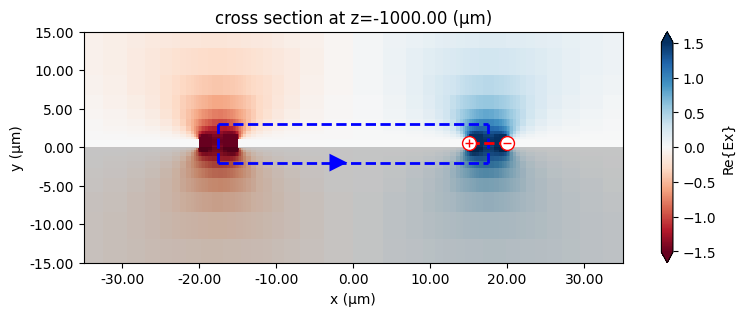

In [19]:
# Plot V and I integration paths
fig, ax = plt.subplots(figsize=(10, 3))
mode_solver.plot_field(field_name="Ex", val="real", f=f0, ax=ax)
current_spec.plot(z=-L / 2, ax=ax)
voltage_spec.plot(z=-L / 2, ax=ax)
ax.set_xlim(-WS - G, WS + G)
ax.set_ylim(-15, 15)
plt.show()

For comparison purposes, we import benchmark data obtained from other commercial RF simulation software. 

In [20]:
# Import benchmark data
freqs_ben1, neff_ben1, alphadB_ben1, Zre_ben1 = np.genfromtxt(
    "misc/cpw_fem_mode.csv", delimiter=",", unpack=True
)
freqs_ben2, neff_ben2, alphadB_ben2, Zre_ben2 = np.genfromtxt(
    "misc/cpw_fit_mode.csv", delimiter=",", unpack=True
)

The three quantities are plotted below. The results compare very well with the benchmark data. 

In [21]:
def comparison_plot(data, data_ben1, data_ben2, err_band, ax):
    """Generate comparison plot of three datasets with fractional error band based on dataset"""
    ax.plot(freqs / 1e9, data, label="RF Solver")
    ax.plot(freqs_ben1, data_ben1, ls="--", color="#555555", label="Commercial FEM")
    ax.plot(freqs_ben2, data_ben2, ls=":", color="#555555", label="Commercial FIT")
    ax.fill_between(
        freqs / 1e9,
        (1 + err_band) * data,
        (1 - err_band) * data,
        alpha=0.2,
        color="gray",
        label=f"$\\pm${err_band * 100:.2f}%",
    )

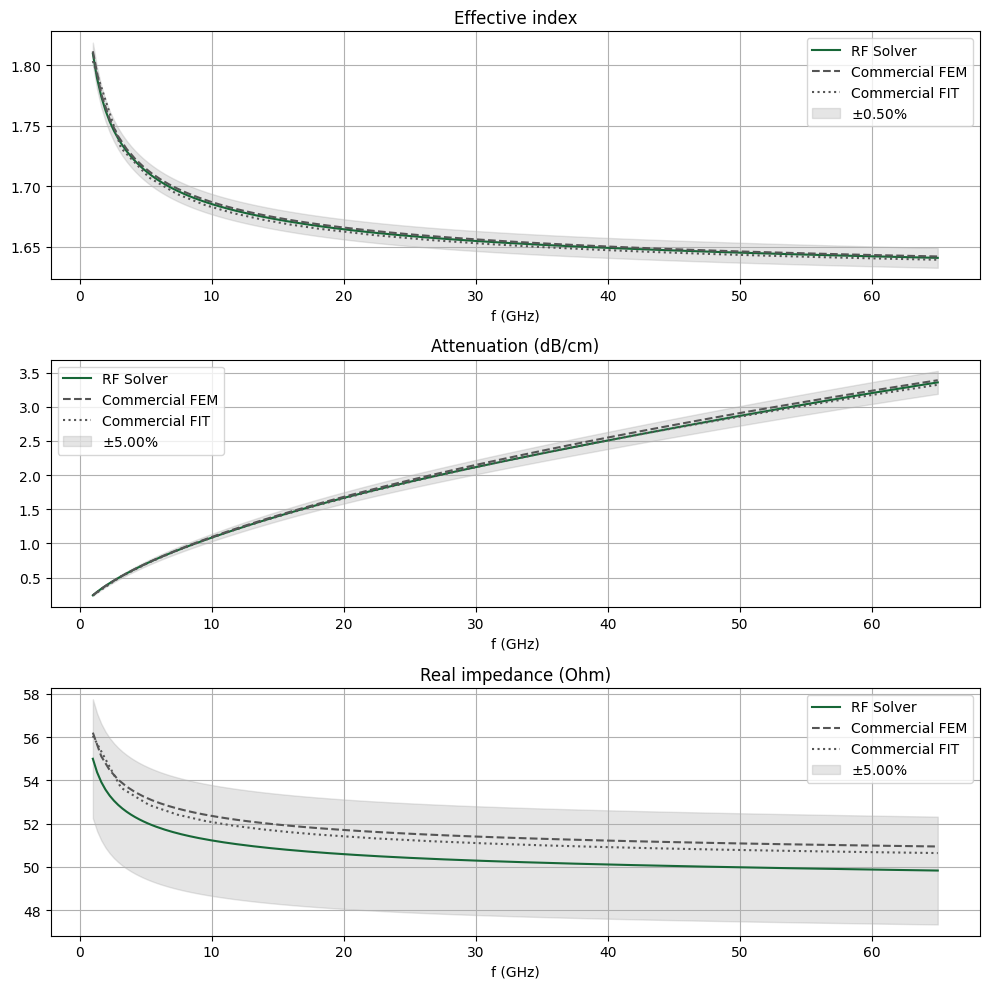

In [22]:
# Comparison plots
fig, ax = plt.subplots(3, 1, figsize=(10, 10), tight_layout=True)
ax[0].set_title("Effective index")
comparison_plot(neff_mode, neff_ben1, neff_ben2, 0.005, ax=ax[0])
ax[1].set_title("Attenuation (dB/cm)")
comparison_plot(alphadB_mode, alphadB_ben1, alphadB_ben2, 0.05, ax=ax[1])
ax[2].set_title("Real impedance (Ohm)")
comparison_plot(np.real(Z0_mode), Zre_ben1, Zre_ben2, 0.05, ax=ax[2])
for axis in ax:
    axis.legend()
    axis.grid()
    axis.set_xlabel("f (GHz)")
plt.show()

### Distributed RLCG transmission line parameters

Using the complex propagation constant $\gamma$ and the line impedance $Z_0$, we can calculate the RLCG parameters using the following relationships:
$$
  R = \text{Re}(\gamma Z_0), \quad L = \text{Im}(\gamma Z_0)/\omega, \quad G = \text{Re}(\gamma/Z_0), \quad C = \text{Im}(\gamma/Z_0)/\omega
$$
where $\omega = 2\pi f$.

In [23]:
R_mode = np.real(gamma_mode * Z0_mode)  # Ohm/mm
G_mode = np.real(gamma_mode / Z0_mode)  # S/mm
L_mode = np.imag(gamma_mode * Z0_mode) / (2 * np.pi * freqs)  # H/mm
C_mode = np.imag(gamma_mode / Z0_mode) / (2 * np.pi * freqs)  # F/mm

The RLCG parameters are shown below. Note that since the dielectric is lossless, $G$ is actually zero and the plotted values are due to numerical noise. 

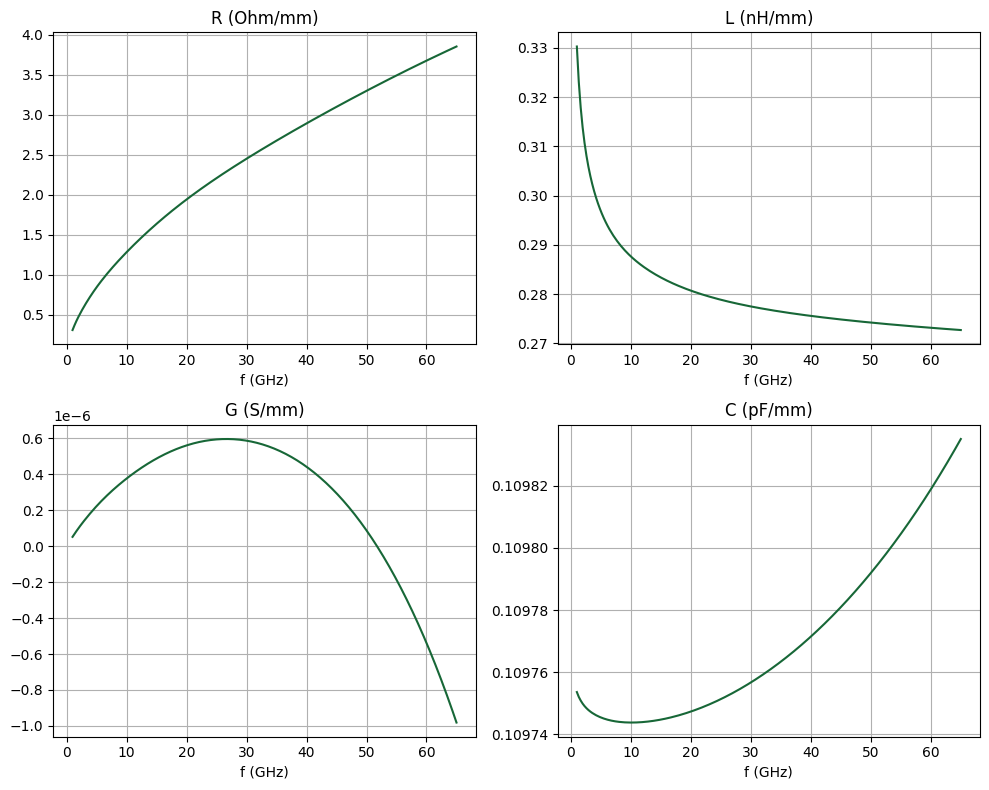

In [24]:
# Plot RLCG
fig, ax = plt.subplots(2, 2, figsize=(10, 8), tight_layout=False)
ax[0, 0].plot(freqs / 1e9, R_mode)
ax[0, 1].plot(freqs / 1e9, L_mode * 1e9)
ax[1, 0].plot(freqs / 1e9, G_mode)
ax[1, 1].plot(freqs / 1e9, C_mode * 1e12)
titles = ["R (Ohm/mm)", "L (nH/mm)", "G (S/mm)", "C (pF/mm)"]
for ii, title in enumerate(titles):
    ax[ii // 2, ii % 2].set_title(title)
    ax[ii // 2, ii % 2].set_xlabel("f (GHz)")
    ax[ii // 2, ii % 2].grid()
plt.show()

## 3D Analysis

### Run Simulation

Let us simulate a short section of the CPW to demonstrate the 3D workflow. First, the grid resolution can be reduced from the 2D case. This is because S-parameters generally converge much more quickly than modal parameters. Below, we redefine the grid specification for the 3D case.

In [25]:
# Layer refinement spec
lr_spec_3d = rf.LayerRefinementSpec.from_structures(
    structures=[str_cpw],
    min_steps_along_axis=2,
    corner_refinement=td.GridRefinement(dl=T / 2, num_cells=2),
    refinement_inside_sim_only=False,
)

# Overall grid specification
grid_spec_3d = td.GridSpec.auto(
    min_steps_per_wvl=12,
    wavelength=td.C_0 / f_max,
    layer_refinement_specs=[lr_spec_3d],
)

We make an updated copy of the base `Simulation` and `TerminalComponentModeler` using the reduced grid specification.

In [26]:
sim_3d = sim.updated_copy(grid_spec=grid_spec_3d)
tcm_3d = tcm.updated_copy(simulation=sim_3d)

The simulation is executed below. 

In [27]:
tcm_data = web.run(tcm_3d, task_name="CPW 3D", path="data/tcm_data_cpw.hdf5")

17:14:35 EST Created task 'CPW 3D' with resource_id                             
             'sid-53f58640-4908-44fa-8b61-14c838eca481' and task_type           
             'TERMINAL_CM'.

             View task using web UI at                                          
             ]8;id=505010;https://tidy3d.simulation.cloud/rf?taskId=pa-090900a3-45da-41c7-8ffe-562a80b4a9c9\'https://tidy3d.simulation.cloud/rf?]8;;\]8;id=772875;https://tidy3d.simulation.cloud/rf?taskId=pa-090900a3-45da-41c7-8ffe-562a80b4a9c9\taskId]8;;\]8;id=505010;https://tidy3d.simulation.cloud/rf?taskId=pa-090900a3-45da-41c7-8ffe-562a80b4a9c9\=]8;;\]8;id=235682;https://tidy3d.simulation.cloud/rf?taskId=pa-090900a3-45da-41c7-8ffe-562a80b4a9c9\pa]8;;\]8;id=505010;https://tidy3d.simulation.cloud/rf?taskId=pa-090900a3-45da-41c7-8ffe-562a80b4a9c9\-090900a3-45da-41c7-8f]8;;\
             ]8;id=505010;https://tidy3d.simulation.cloud/rf?taskId=pa-090900a3-45da-41c7-8ffe-562a80b4a9c9\fe-562a80b4a9c9']8;;\.

             Task folder: ]8;id=76275;https://tidy3d.simulation.cloud/folders/f89aec3e-3357-4624-9c24-096a87582f12\'default']8;;\.

Output()

17:14:43 EST Maximum FlexCredit cost: 0.408. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' after run.

17:14:44 EST Subtasks status - CPW 3D                                           
             Group ID: 'pa-090900a3-45da-41c7-8ffe-562a80b4a9c9'

Output()

             Batch status = preprocess

17:14:50 EST Batch status = running

17:17:17 EST Batch status = postprocess

17:17:42 EST Modeler has finished running successfully.

17:17:43 EST Billed flex credit cost: 0.208.

Output()

17:17:48 EST Loading component modeler data from data/tcm_data_cpw.hdf5

### S-parameters

The S-matrix can be calculated using the `smatrix()` method from the `TerminalComponentModelerData` instance `tcm_data` returned by `web.run()`.

In [28]:
smat = tcm_data.smatrix()

Below, we define some convenience functions to extract the individual $S_{ij}$ entries. The `port_in` and `port_out` coordinates are used to specify the port name/index. Note the use of `np.conjugate()` to convert the S-parameter from the physics phase convention (Tidy3D default) to the standard electrical engineering convention. 

In [29]:
def sparam(i, j):
    return np.conjugate(smat.data.isel(port_in=j - 1, port_out=i - 1))


def sparam_abs(i, j):
    return np.abs(sparam(i, j))


def sparam_angle(i, j):
    return np.unwrap(np.angle(sparam(i, j))) / np.pi * 180


def sparam_dB(i, j):
    return 20 * np.log10(sparam_abs(i, j))

We import some benchmark data for comparison below. 

In [30]:
# Import benchmark data
freqs_ben1, S11abs_ben1, S11arg_ben1, S21abs_ben1, S21arg_ben1 = np.genfromtxt(
    "misc/cpw_fem_sparam.csv", delimiter=",", unpack=True
)
freqs_ben2, S11abs_ben2, S11arg_ben2, S21abs_ben2, S21arg_ben2 = np.genfromtxt(
    "misc/cpw_fit_sparam.csv", delimiter=",", unpack=True
)

The insertion loss magnitude and angle are compared below. They agree very well. 

In [31]:
def comparison_plot_sparam(data, data_ben1, data_ben2, err_band, ax, err_band_on=True):
    """Comparison plot of three datasets with fractional error band based on data1"""
    ax.plot(freqs / 1e9, data, label="RF Solver")
    ax.plot(freqs_ben1, data_ben1, ls="--", color="#555555", label="Commercial FEM")
    ax.plot(freqs_ben2, data_ben2, ls=":", color="#555555", label="Commercial FIT")
    if err_band_on:
        ax.fill_between(
            freqs / 1e9,
            data + err_band,
            data - err_band,
            alpha=0.2,
            color="gray",
            label=f"$\\pm${err_band:.2f} delta S",
        )

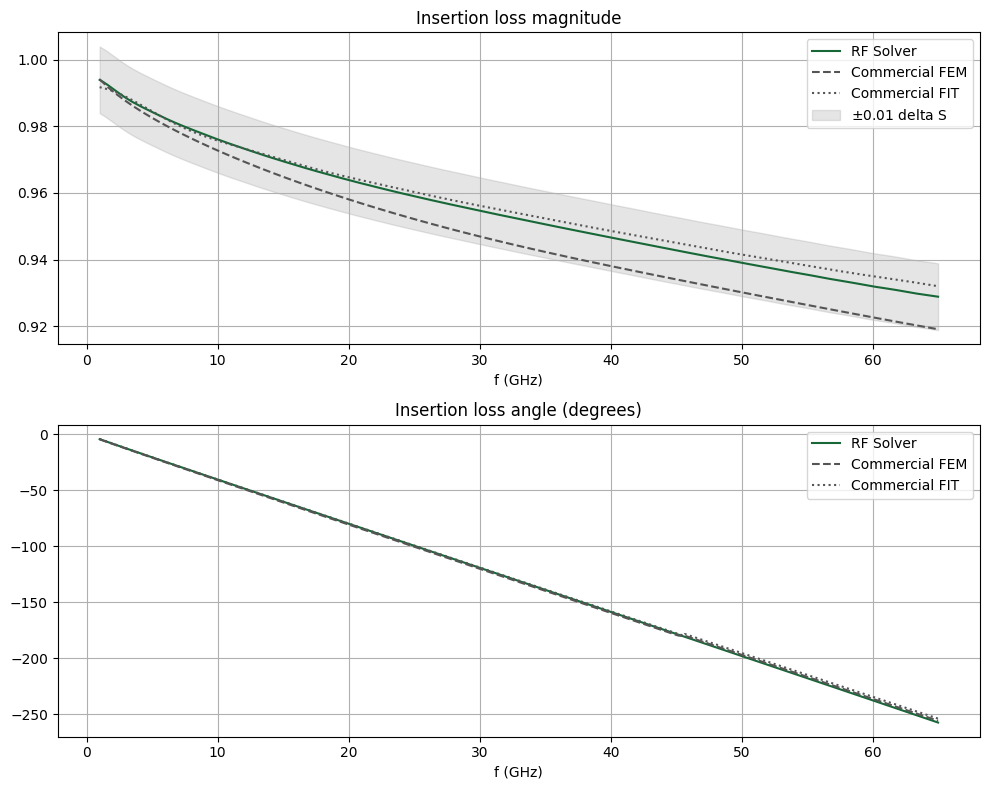

In [32]:
# Compare insertion loss
fig, ax = plt.subplots(2, 1, figsize=(10, 8), tight_layout=True)
ax[0].set_title("Insertion loss magnitude")
comparison_plot_sparam(sparam_abs(2, 1), S21abs_ben1, S21abs_ben2, 0.01, ax=ax[0])
ax[1].set_title("Insertion loss angle (degrees)")
comparison_plot_sparam(
    sparam_angle(2, 1),
    np.unwrap(S21arg_ben1),
    np.unwrap(S21arg_ben2),
    0.0,
    ax=ax[1],
    err_band_on=False,
)
for axis in ax:
    axis.legend()
    axis.grid()
    axis.set_xlabel("f (GHz)")
plt.show()

Since this is a straight transmission line with no longitudinal variation, the return loss should theoretically be zero. Below, we plot the return loss magnitude in dB. The RF solver is able to achieve a very low level of numerical reflection. The propagating mode is very well matched to the modal absorbing boundary present in each wave port. 

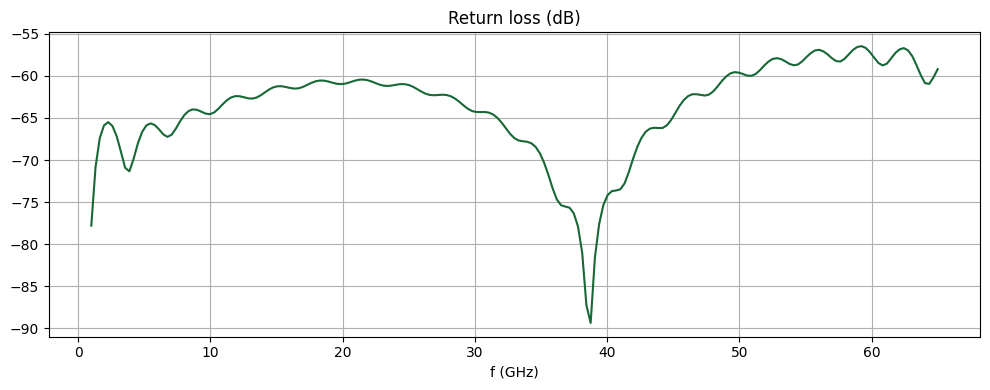

In [33]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True)
ax.set_title("Return loss (dB)")
ax.plot(freqs / 1e9, sparam_dB(1, 1))
ax.grid()
ax.set_xlabel("f (GHz)")
plt.show()

### Field profile

To access the field monitor data, we need to first load the simulation dataset from the `TerminalComponentModelerData` instance. The simulation data is stored in a dictionary indexed by keys in the format `<port name>@<mode number>`. For example, to obtain data for the first (and only) excited mode in wave port 1, we use `WP1@0`.

In [34]:
# Load monitor data
sim_data = tcm_data.data["WP1@0"]

Below, we plot the field magnitude in dB just below the CPW metal plane. (The divide-by-zero error is due to zero field magnitude in some metallic regions.)

/home/dmarek/dev/custom_tidy/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/dmarek/dev/custom_tidy/.venv/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:497: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/dmarek/dev/custom_tidy/.venv/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:500: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


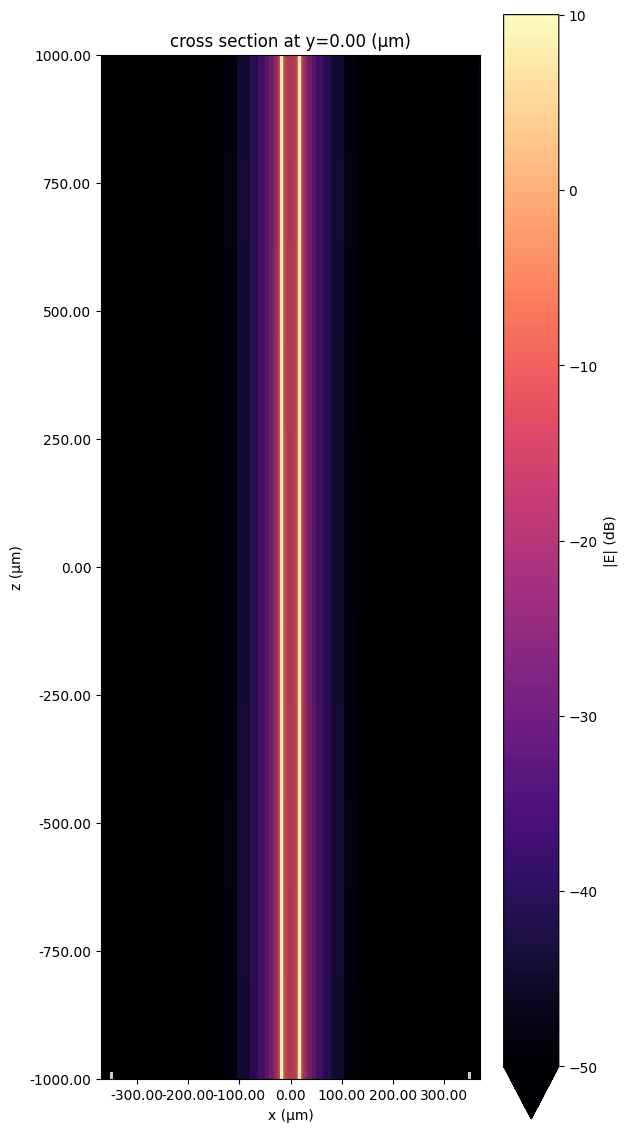

In [35]:
fig, ax = plt.subplots(figsize=(6, 12), tight_layout=True)
sim_data.plot_field(
    "field cpw plane", field_name="E", val="abs", scale="dB", f=f_max, ax=ax, vmin=-50, vmax=10
)
ax.set_xlim(-W_cpw / 2, W_cpw / 2)
ax.set_ylim(-L / 2, L / 2)
plt.show()

## Conclusion

In this notebook, we used the basic CPW as an example to demonstrate the typical Tidy3D RF workflow for modeling transmission lines. We calculated and benchmarked key quantities such as effective index, attenuation, characteristic impedance, and S-parameters. 

In the [next notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/CPWRFPhotonics2/), we will model the CPW in the context of a Mach-Zehnder modulator. 